### 1. Ucitavaju se potrebne biblioteke

In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [ ]:
torch.__version__

'1.3.0+cu100'

In [ ]:
! pip install gdown
import gdown

url = 'https://drive.google.com/uc?id=1kHEZqSyeU3jT0c7co_jC7kFAcIZb5Q1a'
output = 'alien-predator-data.tar.gz'
gdown.download(url, output, quiet=True)

'alien-predator-data.tar.gz'

In [ ]:
%%capture
! tar -xvf alien-predator-data.tar.gz
! mkdir models

In [ ]:
! ls

alien-predator-data.tar.gz  data  models  sample_data


### 2. Konstruisemo objekte za ucitavanje podataka

In [ ]:
# Definisemo niz transformacija
# koje ce biti automatski primenjene pri ucitavaju podataka
# Parametri su odabrani na osnovu ImageNet podataka.
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
        transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize
        ]),
    'validation':
        transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize
        ]),
}

image_datasets = {
    'train': 
        datasets.ImageFolder('data/train', data_transforms['train']),
    'validation': 
        datasets.ImageFolder('data/validation', data_transforms['validation'])
}

dataloaders = {
    'train':
        torch.utils.data.DataLoader(image_datasets['train'],
                                    batch_size=32,
                                    shuffle=True, num_workers=4),
    'validation':
        torch.utils.data.DataLoader(image_datasets['validation'],
                                    batch_size=32,
                                    shuffle=False, num_workers=4)
}

### 3. Create the network

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

### 4. Train the model

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.float() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss.item(),
                                                        epoch_acc.item()))
    return model

In [ ]:
model_trained = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 1/10
----------
train loss: 0.6511, acc: 0.6153
validation loss: 0.4716, acc: 0.8200
Epoch 2/10
----------
train loss: 0.3687, acc: 0.8746
validation loss: 0.2994, acc: 0.9000
Epoch 3/10
----------
train loss: 0.2572, acc: 0.9107
validation loss: 0.3189, acc: 0.8350
Epoch 4/10
----------
train loss: 0.2033, acc: 0.9236
validation loss: 0.2416, acc: 0.8850
Epoch 5/10
----------
train loss: 0.1680, acc: 0.9280
validation loss: 0.2613, acc: 0.8750
Epoch 6/10
----------
train loss: 0.1692, acc: 0.9380
validation loss: 0.2184, acc: 0.9100
Epoch 7/10
----------
train loss: 0.1357, acc: 0.9424
validation loss: 0.1878, acc: 0.9150
Epoch 8/10
----------
train loss: 0.1561, acc: 0.9395
validation loss: 0.2002, acc: 0.9100
Epoch 9/10
----------
train loss: 0.1280, acc: 0.9553
validation loss: 0.1946, acc: 0.9150
Epoch 10/10
----------
train loss: 0.1162, acc: 0.9568
validation loss: 0.2391, acc: 0.9000


### 5. Save and load the model

In [ ]:
! mkdir -p models/pytorch

In [ ]:
torch.save(model_trained.state_dict(), 'models/pytorch/weights.h5')

In [ ]:
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
model.load_state_dict(torch.load('models/pytorch/weights.h5'))

<All keys matched successfully>

### 6. Make predictions on sample test images

In [ ]:
validation_img_paths = ["data/validation/alien/11.jpg",
                        "data/validation/alien/22.jpg",
                        "data/validation/predator/33.jpg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

In [ ]:
validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])

In [ ]:
pred_logits_tensor = model(validation_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()

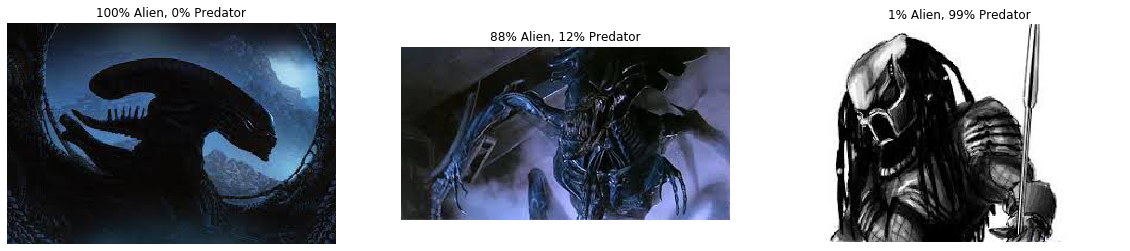

In [ ]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*pred_probs[i,0],
                                                          100*pred_probs[i,1]))
    ax.imshow(img)